# Image Segmentation

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

## Data 준비하기

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/seg_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/seg_val.tfr'

# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        class_list.append(line)

In [4]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}

## Segmentation

In [5]:
IMG_SIZE = 224
N_CLASS = len(class_list)

N_EPOCHS = 10
N_BATCH = 32

learning_rate = 0.0001

N_TRAIN = 6000
N_VAL = 1378
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'seg': tf.io.FixedLenFeature([], tf.string)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)    
    seg = tf.reshape(seg, [IMG_SIZE, IMG_SIZE, -1])
    seg = tf.cast(seg, tf.float32)
    
    return image, seg

In [7]:
## train dataset
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [8]:
## validation dataset
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

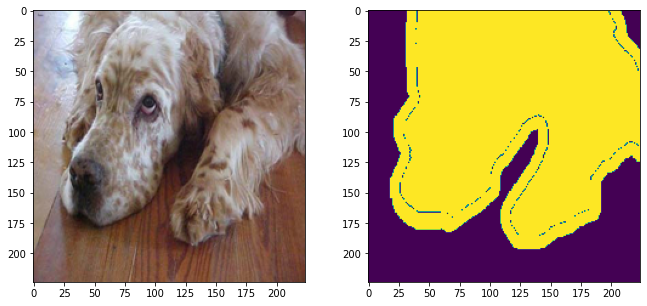

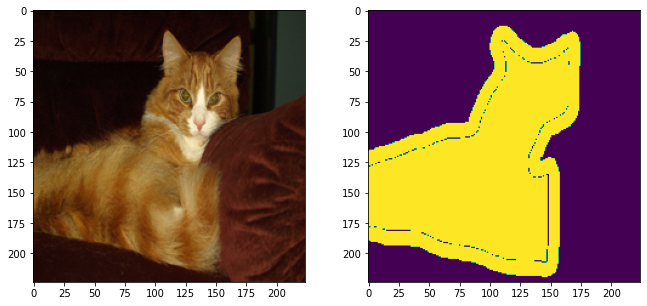

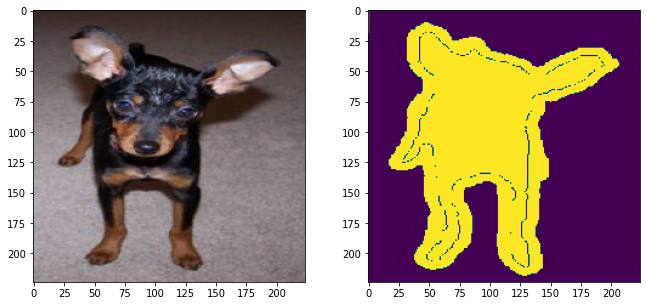

In [9]:
## image segmentation 확인
for image, seg in val_dataset.take(3):
    plt.figure(figsize=(11,5))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(seg[0,:,:,0])
    plt.show()   

### U-Net like model을 random intialization으로 학습하기

In [10]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [11]:
def create_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)    
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 

In [12]:
model = create_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.4,
                                                          staircase=True)

## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [13]:
model.fit(train_dataset, 
          epochs=N_EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps)

Epoch 1/10
187/187 [==============================] - 352s 2s/step - loss: 0.5687 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.4739 - val_sparse_categorical_accuracy: 0.7873
Epoch 2/10
187/187 [==============================] - 307s 2s/step - loss: 0.4079 - sparse_categorical_accuracy: 0.8183 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8281
Epoch 3/10
187/187 [==============================] - 289s 2s/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.3087 - val_sparse_categorical_accuracy: 0.8670
Epoch 4/10
187/187 [==============================] - 289s 2s/step - loss: 0.2994 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.2830 - val_sparse_categorical_accuracy: 0.8808
Epoch 5/10
187/187 [==============================] - 289s 2s/step - loss: 0.2725 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.2589 - val_sparse_categorical_accuracy: 0.8947
Epoch 6/10
187/187 [==============================] - 289s 2s/step - loss: 0.2457 - sparse_cate

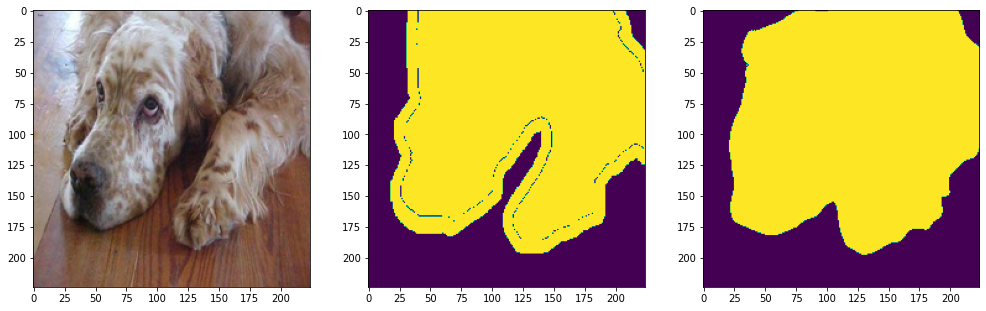

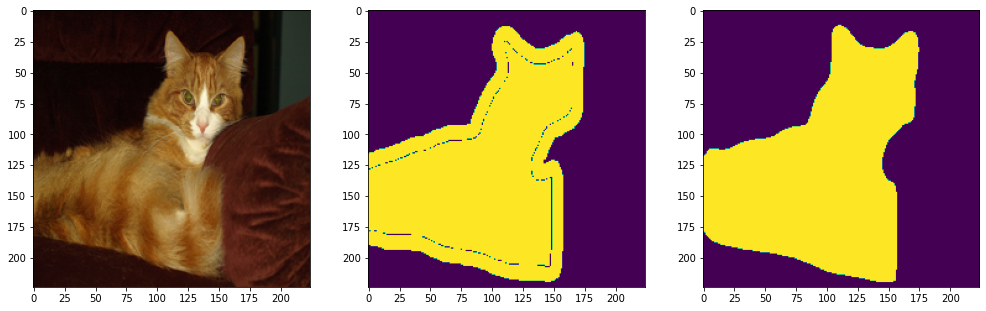

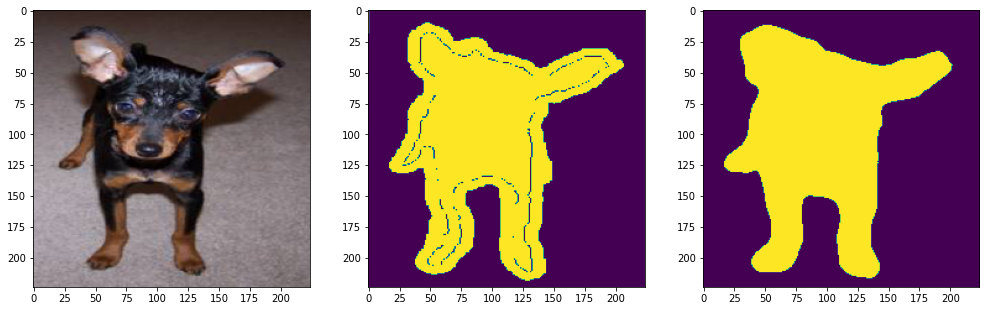

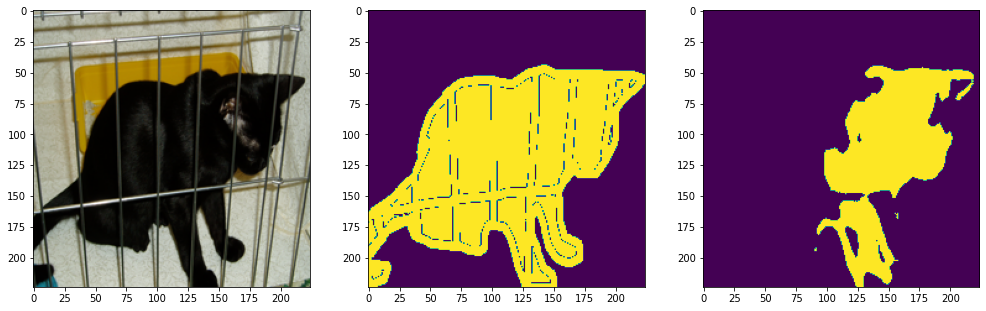

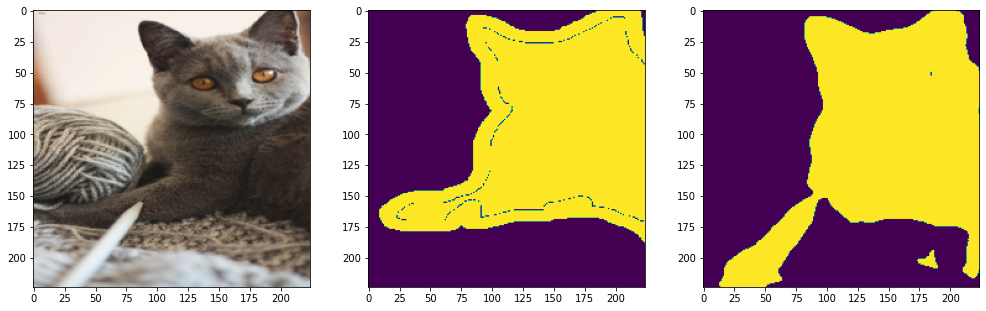

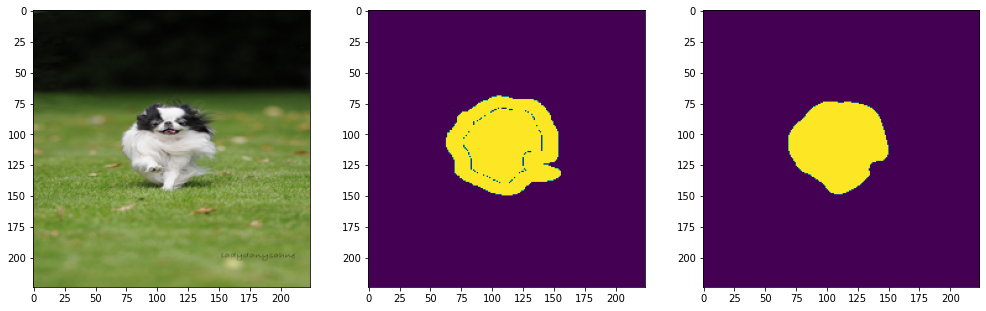

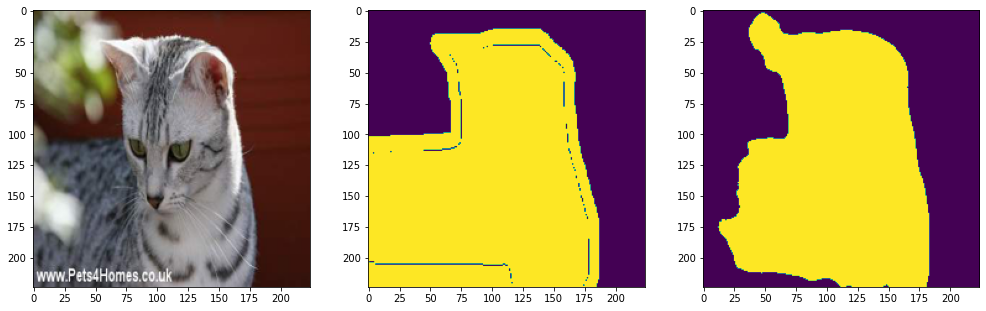

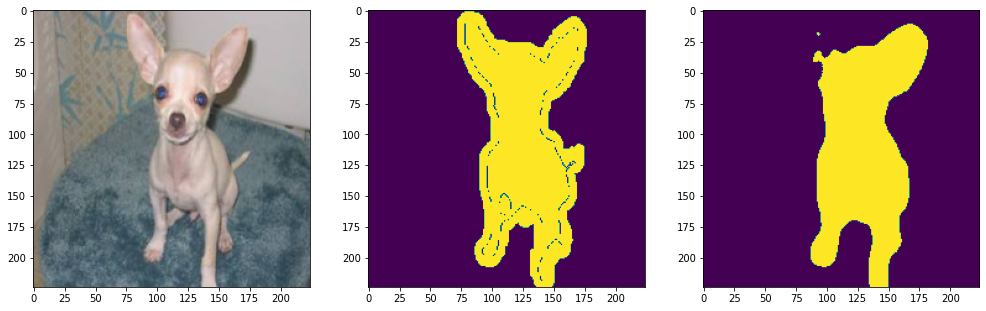

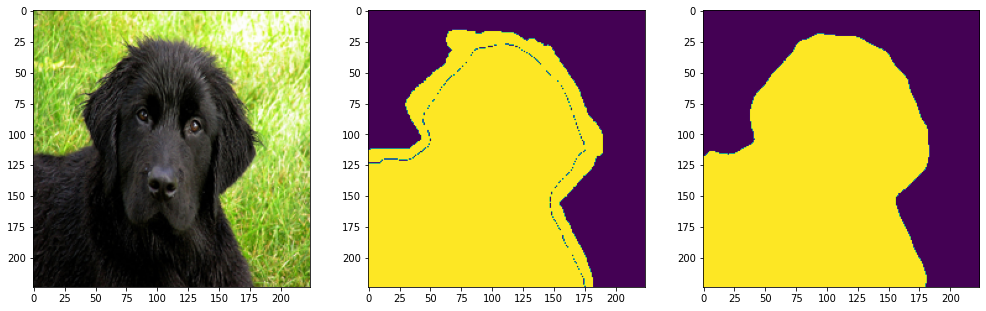

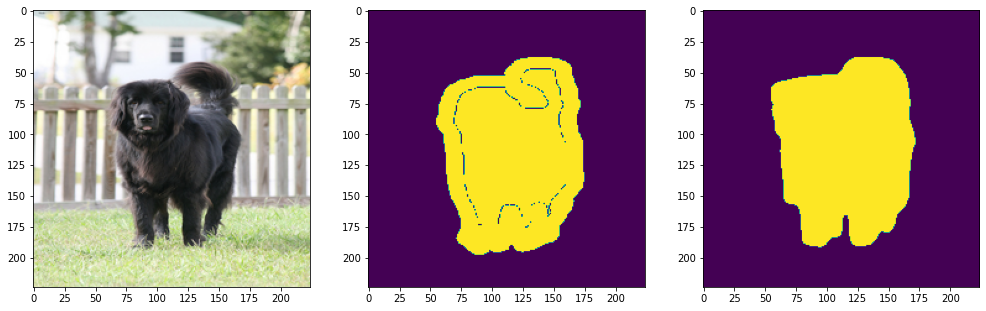

In [14]:
## validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)

    plt.subplot(num_imgs,3,idx*3+3)
    ## validation data에 대한 예측값 생성
    prediction = model.predict(image)    
    pred = np.zeros_like(prediction)
    ## 0.5이상은 1로 나머지는 0으로 변환
    threshold = 0.5
    pred[prediction>=threshold] = 1
    pred[prediction<threshold] = 0
    plt.imshow(pred[0,:,:,1])
    plt.show() 
    idx += 1

In [15]:
## IOU 계산
avg_iou = 0
n = 0
threshold = 0.5
for images, labels in val_dataset.take(validation_steps):  
    preds = model.predict(images)
    preds[preds>=threshold] = 1
    preds[preds<threshold] = 0

    psum = labels[...,0] + preds[...,1]

    union = np.array(psum)
    union[union>1] = 1.
    union = np.sum(union, axis=1)
    union = np.sum(union, axis=1)

    inter = np.array(psum)
    inter[inter==1] = 0.
    inter[inter>1] = 1.  
    inter = np.sum(inter, axis=1)
    inter = np.sum(inter, axis=1)

    iou = inter / union  
    avg_iou += np.sum(iou) / N_VAL

print(avg_iou)

0.8086599736151397


## U-Net like model에 pretrained VGG를 활용하여 학습하기

In [16]:
from tensorflow.keras.utils import get_file

In [17]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                       'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
def create_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    ## loading vgg16 pretrained weights
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 

In [19]:
model = create_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.4,
                                                          staircase=True)

model.compile(keras.optimizers.Adam(lr_schedule), 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [20]:
model.fit(train_dataset, 
          epochs=N_EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps)

Epoch 1/10
187/187 [==============================] - 293s 2s/step - loss: 0.2852 - sparse_categorical_accuracy: 0.8768 - val_loss: 0.1882 - val_sparse_categorical_accuracy: 0.9251
Epoch 2/10
187/187 [==============================] - 291s 2s/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.1449 - val_sparse_categorical_accuracy: 0.9460
Epoch 3/10
187/187 [==============================] - 290s 2s/step - loss: 0.1333 - sparse_categorical_accuracy: 0.9508 - val_loss: 0.1596 - val_sparse_categorical_accuracy: 0.9405
Epoch 4/10
187/187 [==============================] - 290s 2s/step - loss: 0.1249 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.1413 - val_sparse_categorical_accuracy: 0.9475
Epoch 5/10
187/187 [==============================] - 290s 2s/step - loss: 0.1123 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.1438 - val_sparse_categorical_accuracy: 0.9465
Epoch 6/10
187/187 [==============================] - 290s 2s/step - loss: 0.1089 - sparse_cate

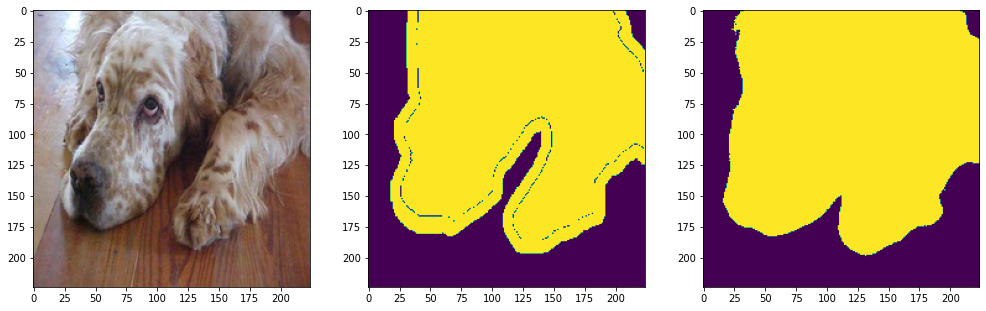

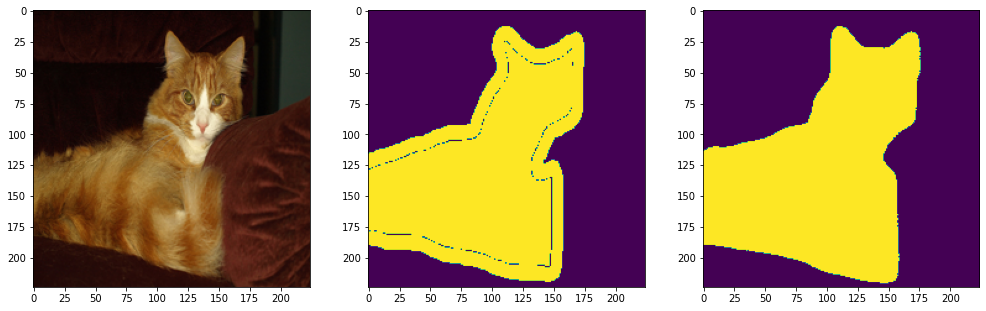

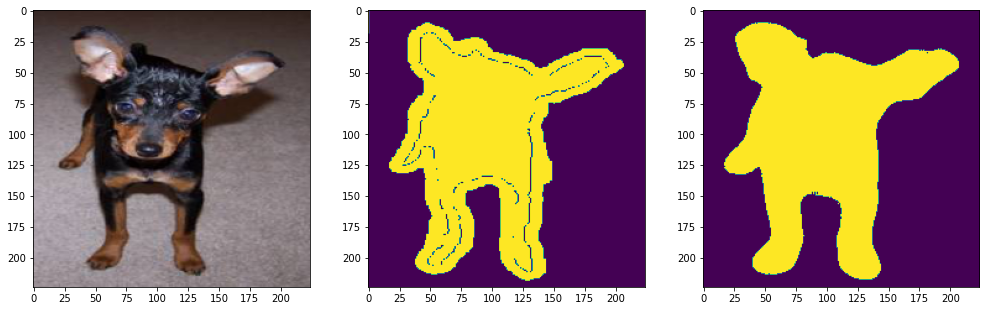

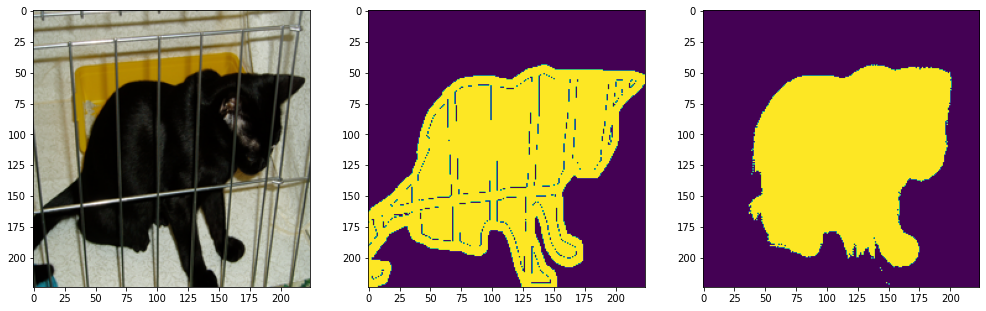

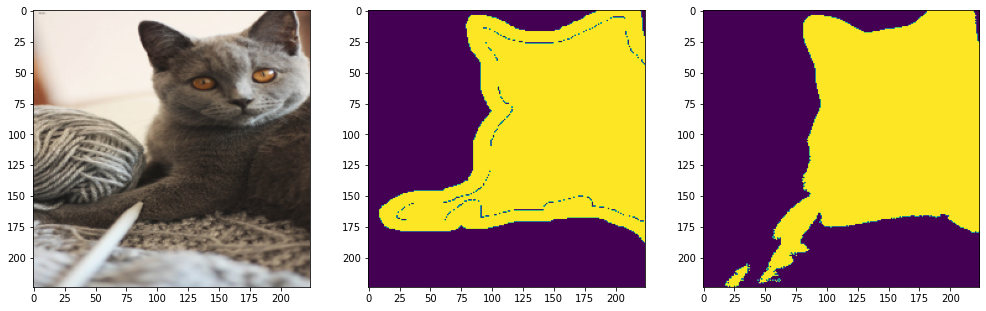

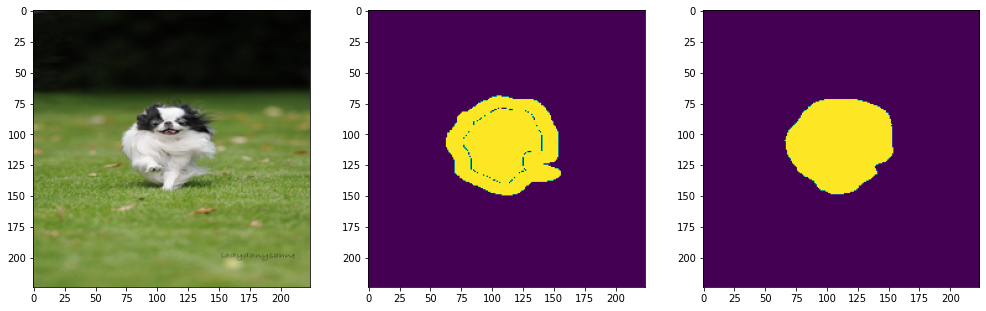

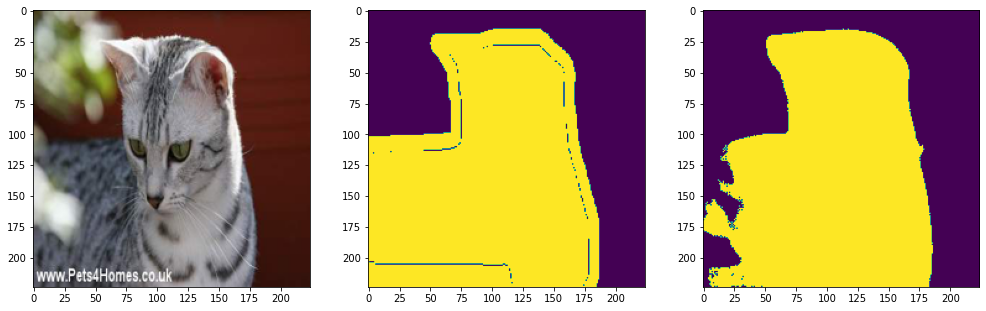

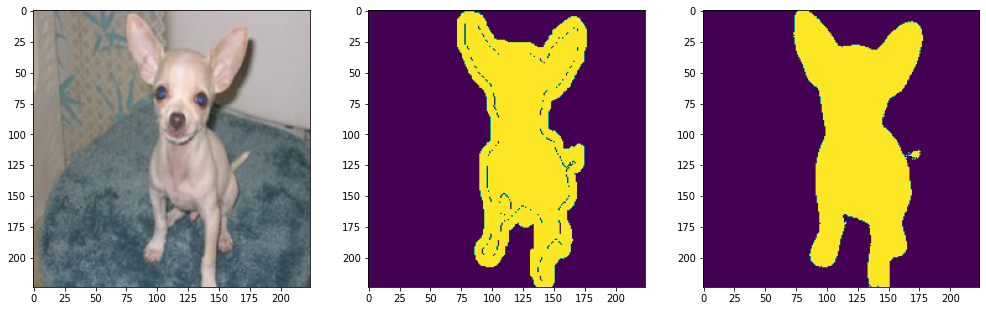

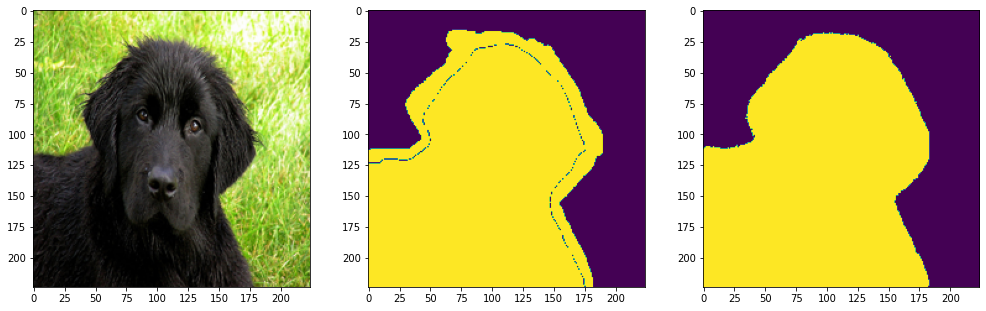

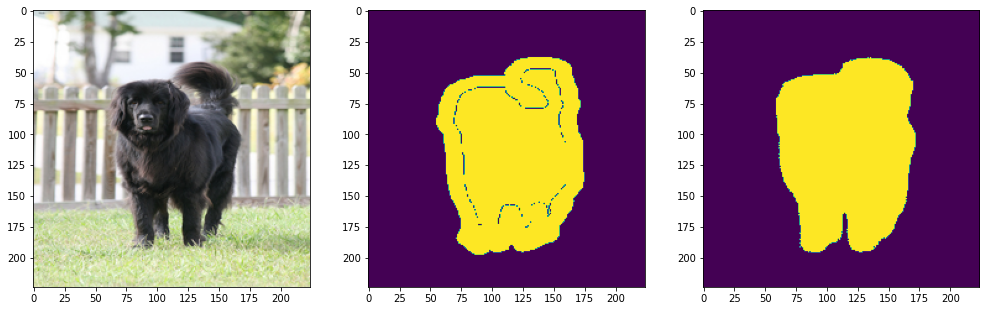

In [21]:
## validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)

    plt.subplot(num_imgs,3,idx*3+3)
    ## validation data에 대한 예측값 생성
    prediction = model.predict(image)    
    pred = np.zeros_like(prediction)
    ## 0.5이상은 1로 나머지는 0으로 변환
    thr = 0.5
    pred[prediction>=thr] = 1
    pred[prediction<thr] = 0
    plt.imshow(pred[0,:,:,1])
    plt.show() 
    idx += 1

In [22]:
## IOU 계산
avg_iou = 0
n = 0
thr = 0.5
for images, labels in val_dataset.take(validation_steps):  
    preds = model.predict(images)
    preds[preds>=thr] = 1
    preds[preds<thr] = 0

    psum = labels[...,0] + preds[...,1]

    union = np.array(psum)
    union[union>1] = 1.
    union = np.sum(union, axis=1)
    union = np.sum(union, axis=1)

    inter = np.array(psum)
    inter[inter==1] = 0.
    inter[inter>1] = 1.  
    inter = np.sum(inter, axis=1)
    inter = np.sum(inter, axis=1)

    iou = inter / union  
    avg_iou += np.sum(iou) / N_VAL

print(avg_iou)

0.8930317347731401


## 새로운 Image로 Test하기

In [23]:
test_image = '/content/drive/MyDrive/Colab/test_cat.jpg'

image = Image.open(test_image)
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

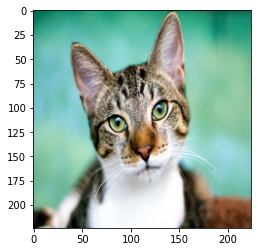

In [24]:
plt.imshow(image)
plt.show()

In [25]:
image = np.reshape(image, (1, 224, 224, 3))

In [26]:
prediction = model.predict(image)
prediction.shape

(1, 224, 224, 2)

In [27]:
pred = np.zeros_like(prediction)
## 0.5이상은 1로 나머지는 0으로 변환
thr = 0.5
pred[prediction>=thr] = 1
pred[prediction<thr] = 0

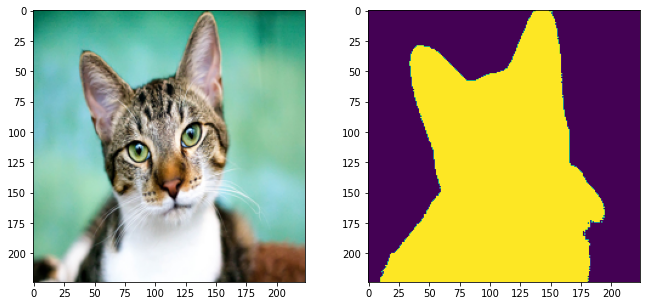

In [28]:
## 예측 결과 확인
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.imshow(image[0])
plt.subplot(1,2,2)
plt.imshow(pred[0,:,:,1])
plt.show()  